Source file for the documentation in the [jupyter notebook](SoundTransmissionThroughGaps.ipynb) and converted to markdown by `jupyter nbconvert`

Sound Transmission Trough Gaps
============================

## Problem Definition

This example illustrates the use of openCFS to evaluate an acoustic wave passing through a periodic interface. The goal is to extract the reflection and transmission coefficients dependent on the incoming wave's frequency and angle of incidence.

The problem is simulated in a 2D domain. The simulated domain represents only a small section of the real domain in y-Direction. Therefore a periodic boundary condition is used on the top and bottom boundary. This leads to the following domain, which has to be simulated. As a soundhard interface, several discs are choosen in this first simulation.

![full_domain](Files/full_domain.png)

The transmission coefficient is defined as

$$ \tau=\frac{P_{trans}}{P_{inc}}, $$

and the reflection coefficient as

$$ r=\frac{P_{refl}}{P_{inc}}. $$

Therefore the calculation of the Transmittet Acoustic Power $P_{trans}$, the Reflected Acoustic Power $P_{refl}$ and the Incoming Acoustic Power $P_{inc}$ has to be performed to obtain both coefficients.

$P_{trans}$ can be evaluated by calculating the power after the interface in the domain. Using openCFS post-processing, the Power can be calculated as a Surface Region Result `acouPower`.

For calculating $P_{inc}$, a second domain, the "excitation domain" is simulated, which only represents the excitation side of the full problem, thus allowing to obtain only the incoming acoustic field. The acoustic power calculated within this domain represents the incoming power. Here the power is also calculated as a Surface Region Result `acouPower`.<br>
However, since the incoming wave is a plane acoustic wave and the relation $v_{\mathrm{a}}=\frac{p_{\mathrm{a}}}{\rho \cdot c}$ holds, this power can easily be calculated analytically. With the definition of the acoustic power $P_{\mathrm{a}}=\int_{\Gamma} \mathbf{I}_{\mathrm{a}} \cdot \mathbf{n} \mathrm{d} \Gamma^{\prime}$. This leads to the equation for the power of the incoming as

$$ P_{inc}=\frac{p_{\mathrm{a}}^2}{2 \cdot \rho \cdot c}\cdot cos(\alpha) \cdot L. $$

Here $p_{\mathrm{a}}$ is the amplitude of the applied acoustic pressure, $\rho$ is the density of air, $c$ the speed of sound, $\alpha$ the angle of the applied wave field and $L$ the heigth of the simulated domain.

![incoming_domain](Files/incoming_domain.png)

Obtaining $P_{refl}$ is the most difficult part, since it can't be done directly via openCFS. When simulating the entire domain, the acoustic field on the incoming side of the domain represents the reflected wave superimposed with the incoming wave. Therefore, the wavefield obtained by simulating the excitation domain has to be subtracted from the full simulations' wavefield. This provides the reflected acoustic field which susequently allows the calculation of the reflected power.<br>
With the acoustic fields for both domains obtained via openCFS, the following substraction and calculation of $P_{refl}$ is done in Python.


## Meshing

The mesh input file is generated with [gmsh](https://gmsh.info/) and subsequently, the mesh file is produced with the command 
```XML
gmsh mesh_input.geo -2 -v 0 -format msh2 -o mesh.msh
```
The provided files are:<br>
- The mesh input file for the full domain  [geometry_total.geo](Files/geometry_discs.geo)<br>
- The mesh input file for the excitation domain  [geometry_excitation.geo](Files/geometry_incoming.geo)<br>

## XML Simulation Files

Now two XML files for harmonic acoustic analysis are set up. One for simulating the incoming acoustic field, hence the excitation domain, provided [here](Files/incoming_simulation.xml), and one for simulating the entire domain with the interface, provided [here](Files/full_simulation.xml). In addition to that, the XML [material file](Files/mat_accou.xml) is required.

The angle of incidence $\alpha$ can be chosen in the XML file by adjusting this value

```XML
<var name="alpha" value="30"/>
```

The simulated frequencies for the harmonic analysis are calculated within the XML file. Due to the periodic boundary condition, the frequencies for the harmonic analysis can not be chosen arbitrarily. They are calculated, depending on the angle of incidence $\alpha$, the height of the domain and the speed of sound $c$. With these frequencies, a plane wave field can be produced in combination with the periodicity of the domain's boundary. Additionally an if-condition is implemented when calculating the frequencies, to directly set the frequencies in the case of $\alpha=0°$.

```XML
<frequencyList>
	<freq value="(alpha != 0)? (1*k*c)/(heigth*abs(sin(alpha*pi/180))): 200" />
	<freq value="(alpha != 0)? (2*k*c)/(heigth*abs(sin(alpha*pi/180))): 300" />
	<freq value="(alpha != 0)? (3*k*c)/(heigth*abs(sin(alpha*pi/180))): 400" />
	<freq value="(alpha != 0)? (4*k*c)/(heigth*abs(sin(alpha*pi/180))): 500" />
	<freq value="(alpha != 0)? (5*k*c)/(heigth*abs(sin(alpha*pi/180))): 600" />
	<freq value="(alpha != 0)? (6*k*c)/(heigth*abs(sin(alpha*pi/180))): 700" />
	<freq value="(alpha != 0)? (7*k*c)/(heigth*abs(sin(alpha*pi/180))): 800" />
	<freq value="(alpha != 0)? (8*k*c)/(heigth*abs(sin(alpha*pi/180))): 900" />
	<freq value="(alpha != 0)? (9*k*c)/(heigth*abs(sin(alpha*pi/180))): 1000" />
	<freq value="(alpha != 0)? (10*k*c)/(heigth*abs(sin(alpha*pi/180))): 1100" />
</frequencyList>
```

For the subtraction of the incoming wave field from the entire wave field, it suffices to only execute this for one line in the domain and then calculate the power along this line. Therefore, in both simulated domains, a sensor array is set up at the same position to calculate the acoustic pressure and the velocity along a vertical line in the domain. 

```XML
<sensorArray type="acouPressure" fileName="PressureArray">
    <parametric>
        <list comp="x" start="-2.46" stop="-2.46" inc="0"/>
        <list comp="y" start="0.025" stop="9.975" inc="0.05"/>
    </parametric>
</sensorArray>

<sensorArray type="acouVelocity" fileName="VelocityArray">
    <parametric>
        <list comp="x" start="-2.46" stop="-2.46" inc="0"/>
        <list comp="y" start="0.025" stop="9.975" inc="0.05"/>
    </parametric>
</sensorArray>
```

The power of the incoming acoustic wave is directly calculated by using the openCFS post-processing in the excitation domain. By the same approach, the transmitted acoustic power is calculated using the entire domain.

## Python Post-processing

The calculation of acoustic power reflected by the interface is carried out in Python. Note that much of the coding is done using pandas dataframes. This allows for a comprehensible code without the excessive use of comments. This code is provided [here](Calculate_Coefficients.ipynb).

First, some libraries are imported.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

### Functions

Now the functions, which are defined [functions.py](functions.py) are imported.

The first function, `calculate_power`, reads the text files, created by the openCFS sensor arrays. Therefore the function needs the information of the angle of incidence and the name of the simulation in order to find the right files. Moreover the number of frequencies which were simulated in openCFS have to be provided. For each frequency the sensor array creates a separate file, hence this information is needed to know how many files have to be read. After reading the files, the velocities and the pressures of the excitation domain are subtracted from the entire domain's to obtain only the values for the reflected acoustic field. With these resulting values the acoustic intensity and subsequently the reflected acoustic power are calculated and returned.

The function `read_inc_power` reads the power of the incoming acoustic field, which is calculated with openCFS directly by using the excitation domain and stored in a text file. The angle of incidence has to be passed over to this function as well, to choose the right file to read the data from. In addition to the power, the frequency for each simulation is stored in the same file, which is read and saved by the function as well.

The last function, `read_trans_power`, similar to the second function, is created to read and store the power transmitted through the interface.

In [2]:
from functions import calculate_power
from functions import read_inc_power
from functions import read_trans_power

### Main Program

Now all functions are defined and the main part of the code starts. First, the information on the performed simulations has to be defined. Simulations for five angles of incidence (60°, 30°, 0°, -30°, 60°) with ten simulated frequencies per angle, have been carried out. The performed simulations were stored by the name "Discs".

In [3]:
# defining which simulation to process
simulation="Discs" # for getting the coefficients of the original domain (discs as iterface)
angles_str = ["60", "30", "00", "m30", "m60"] # angles of incidence which were simulated (m for minus)
freq_num=10 # number of frequencies which were simulated

In the next step some empty dataframes and arrays are defined, needed in the following parts of the code.

In [4]:
# vector for storing dataframe of the calculation for reflected power
results_dataframes = [None] * len(angles_str) 

# empty dataframes for power calculation  
df_Power_ref = pd.DataFrame()
df_Power_inc = pd.DataFrame()
df_Power_trans = pd.DataFrame()
df_Power_balance = pd.DataFrame()
df_Coefficients = pd.DataFrame()

Following this, a for-loop over all angles of incidence is created. In this loop, the reflected, transmitted and incoming powers are calculated with the predefined functions and stored in the dataframes.

With the determined powers, a power balance around the interface is set up. This step is not necessary for the calculation of the coefficients, but is a good way of validating the data obtained up until now. Since the interface in the performed simulation is soundhard, the power balance $P_{inc}=P_{refl}+P_{trans}$ has to be fulfilled. The relative error of this balance is calculated and used for validating the obtained powers.

The last step performed in the loop is the calculation of the transmission coefficient and the reflection coefficient.

In [5]:
# for loop over all simulated incidence angles
for index, angle in enumerate(angles_str):
    
    # calcualting power reflected from interface
    [df,Power_ref]=calculate_power(angle,simulation,freq_num)  
    results_dataframes[index]=df  
    df_Power_ref[angle]=np.concatenate(Power_ref)
    
    # reading the incoming power
    [Power_inc,frequency]=read_inc_power(angle)
    df_Power_inc['freq_'+angle]=frequency
    df_Power_inc[angle]=Power_inc
     
    # reading the transmitted power
    [Power_trans]=read_trans_power(angle,simulation)
    df_Power_trans['freq_'+angle]=frequency
    df_Power_trans[angle]=Power_trans

    # check the power balance (for soundhard interface: P_inc=P_refl+P_trans)
    df_Power_balance['balance_'+angle]=df_Power_inc[angle]-df_Power_trans[angle]-df_Power_ref[angle]
    df_Power_balance['Error_in_%_'+angle]=abs(df_Power_balance['balance_'+angle]/df_Power_inc[angle])*100 

    # calculate transmission and reflection coefficients
    df_Coefficients['Trans_coef_'+angle]=df_Power_trans[angle]/df_Power_inc[angle]
    df_Coefficients['Refl_coef_'+angle]=df_Power_ref[angle]/df_Power_inc[angle]


### Plot Coefficients

For showing the obtained coefficients two plots are created. The first shows the **transmission coefficients** depending on the angle of incidence and the excitation frequency.

This plot shows, that the calculated coefficients are nearly the same when simply the sign of the incidence angle is switched. Considering the interface being symmetrical along the x-axis, this is an expected result. In fact, the transmission coefficients should be exactly the same. <br>
The encountered small deviations might be due to the postprocessing procedure and indicate the overall error that can be expected from it.<br>

By simply looking at the interface, one can assume, that the transmitted power has a maximum by an incoming wavefront parallel to the interface and that this transmitted power decreases with a rising angle of incidence. This presumption is also confirmed by the calculated transmission coefficient, which on average has a maximum at an angle of incidence of $\alpha=0°$.

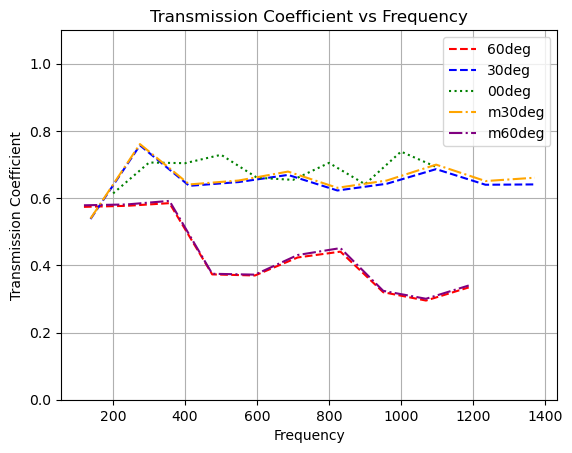

In [6]:
# Plotting Transmission Coefficients
colors = ['red', 'blue', 'green', 'orange', 'purple']
line_styles = ['--', '--', ':', '-.', '-.']
for index, angle in enumerate(angles_str):
    plt.plot(df_Power_trans['freq_'+angle], df_Coefficients['Trans_coef_'+angle], 
             linestyle=line_styles[index], color=colors[index], label=angle+'deg')
plt.xlabel('Frequency')
plt.ylabel('Transmission Coefficient')
plt.ylim(0, 1.1) 
plt.grid(True)
plt.legend()
plt.title('Transmission Coefficient vs Frequency')
plt.show()

In the same manner, the **reflection coefficients** are plotted.

With the interface being soundhard no acoustic power is absorbed by it. Knowing the transmission coefficient, the reflection coefficient can be simply calculated, using $r=1-\tau$ as well. Similar to the power balance, this equation can be used to verify the obtained coefficients.<br>
Looking at the plot, it can be seen, that the reflection coefficients for $\alpha=30°$ and $\alpha=-30°$ almost perfectly coincide, contrary to the transmission coefficients. This indicates that there are some small inconsistencies when calculating the transmitted power.

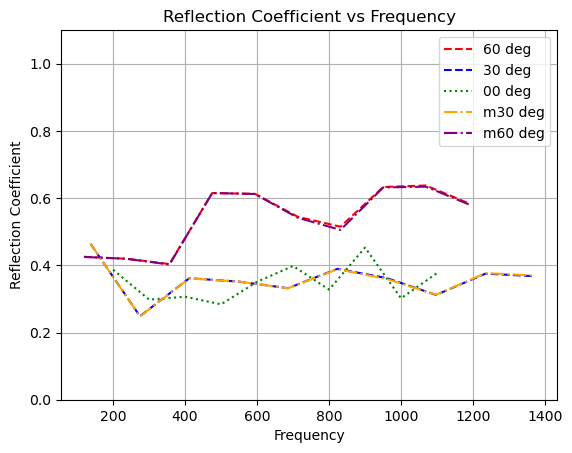

In [7]:
# Plotting Reflection Coefficients
colors = ['red', 'blue', 'green', 'orange', 'purple','black']
line_styles = ['--', '--', ':', '-.', '-.']
for index, angle in enumerate(angles_str):
    plt.plot(df_Power_trans['freq_'+angle], df_Coefficients['Refl_coef_'+angle], 
             linestyle=line_styles[index], color=colors[index], label=angle+' deg')
plt.xlabel('Frequency')
plt.ylabel('Reflection Coefficient')
plt.ylim(0, 1.1)
plt.grid(True)
plt.legend()
plt.title('Reflection Coefficient vs Frequency')
plt.show()

## Interface with Tilted Slits

For further testing of the implemented methods, a second interface geometry is set up and simulated. The interface is still soundhard but it is not symmetrical around the x-axis.

![full_domain_new](Files/full_domain_new.png)

Here the [mesh input file](Files/geometry_tilted_slits.geo) for the new domain is provided.

### Coefficients
Using the XML files and Python script given above, the transmission and reflection coefficients are obtained as shown in the following plots.

The plot shows a big decrease in the transmission coefficient at $\alpha=-60°$. This is the angle, at which the incoming soundwaves are parallel to the interface's fins, hence this outcome is expected.<br>
At an incidence angle of $\alpha=30°$, the soundwaves are orthogonal to the fins, and the highest transmission coefficient is expected. The plot shows, that on average the coefficient at this angle is slightly above the other transmission coefficients. Yet, also for other angles of incidence, similarly high transmission coefficients are reached.<br>
Overall, the plots show that because of the asymmetric interface, both coefficients don't have symmetric behaviour. Moreover, the relation $r=1-\tau$ holds, with some small error, for this simulation as well.  

![trans_coef_new](Files/trans_coef.png)
![refl_coef_new](Files/refl_coef.png)

### Animation

Although the transmission coefficient at $\alpha=-60°$ is on average very low, there are very high fluctuations of the transmission coefficient depending on the frequencies. To understand this behaviour better, an animation of the acoustic pressure field at different frequencies is observed. At $f=237Hz$, the transmission coefficient $\tau=0,93$, meaning that almost all acoustic power passes through the interface. The following gif, displaying the acoustic pressure in the domain, shows that at this frequency the acoustic waves are still able to pass through the interface without losing much energy.

![gif_237Hz](Files/gif_237Hz.gif)


In contrast, the acoustic pressure field at $f=356Hz$ is shown in the next gif. Here $\tau=0,15$, which means only a fraction of the acoustic power is transmitted through the interface. Looking at the animation confirms this. A big portion of the incoming acoustic wave is reflected, leading to a highly reduced pressure on the outgoing side of the interface.

![gif_356Hz](Files/gif_356Hz.gif)

## Script File
To easily run the simulations yourself, a shell script [run.sh](run.sh) is provided. Executing this script in the same folder as the provided `.geo` and `.xml` files will automatically run and store all the necessary openCFS simulations.  

After the simulations are done, the reflection and transmission coefficients can be calculated by opening and running the provided jupyter notebook `Calculate_Coefficients.ipynb` in the same folder. Within the notebook, it is possible to choose whether to calculate the coefficients for the original interface (discs) or for the interface with tilted slits.